## Importing libraries

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

## Generating vocabulary and reading the dataset

In [2]:
lines = open('/Users/yashsurange/Documents/GitHub/Mulitmodal_llms/tinyshakespear.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

First Citizen:
Before we proce


In [4]:
len(vocab)

65

In [24]:
# Approx 1M tokens which here are characters, original llama was trained on 1.4T tokens
len([i for i in lines])


1115393

## Using character level tokenizer for this implementation

In [3]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 65


'hello'

In [20]:
encode('yash')

[63, 39, 57, 46]

In [23]:
decode([23,4,54])

'K&p'

******

### Note 1: Using config object to store parameters. Helps with readability. This will go into a separate file.

*****

In [4]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}


## Creating dataset

In [5]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115393])

## Creating batches


****

### Note 2: Will use same for train, validation and testing. Testing functions on the go is important

*****

In [6]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    
    batch_data = train
    if split == 'val':
        batch_data = val

    if split == 'test':
        batch_data = test
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y


MASTER_CONFIG.update({
    'batch_size': 8,
    'context_window': 16
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('aith hath made a', 'ith hath made a '),
 ('ds.\nFor me, the ', 's.\nFor me, the r'),
 ('he manner is, hi', 'e manner is, his'),
 ('t the crown.\n\nYO', ' the crown.\n\nYOR'),
 ('ust think, if we', 'st think, if we '),
 ('s, that have mor', ', that have more'),
 (" news i' the cou", "news i' the cour"),
 (' your power well', 'your power well ')]

In [72]:
xs[0]

tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42, 57,  6,  0, 21,  1, 41])

In [69]:
ys[0]

tensor([43, 56,  1, 44, 56, 47, 43, 52, 42, 57,  6,  0, 21,  1, 41, 56])

In [58]:
xs[0][:16]

tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42, 57,  6,  0, 21,  1, 41])

In [70]:
for i in range(MASTER_CONFIG['context_window']-1):
  context=xs[0][:i+1]
  target=xs[0][i+1]
  print(f"with context:{context} and target is: {target}")

with context:tensor([50]) and target is: 43
with context:tensor([50, 43]) and target is: 56
with context:tensor([50, 43, 56]) and target is: 1
with context:tensor([50, 43, 56,  1]) and target is: 44
with context:tensor([50, 43, 56,  1, 44]) and target is: 56
with context:tensor([50, 43, 56,  1, 44, 56]) and target is: 47
with context:tensor([50, 43, 56,  1, 44, 56, 47]) and target is: 43
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43]) and target is: 52
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52]) and target is: 42
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42]) and target is: 57
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42, 57]) and target is: 6
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42, 57,  6]) and target is: 0
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42, 57,  6,  0]) and target is: 21
with context:tensor([50, 43, 56,  1, 44, 56, 47, 43, 52, 42, 57,  6,  0, 21]) and target is: 1
with context:tensor([50,

### These are the examples that are packed inside the input

****

### Note 3: To make the model work: 1. shapes of tensors should not cause problems hence no compilation erros 2. model loss should go down. It is useful to create a method to evaluate the model first.

****

## Creating evaluation method

In [7]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [23]:
evaluate_loss(model)

{'train': 4.173913097381591, 'val': 4.173974895477295}

## Creating a simple model- we will build llama by swapping out parts of this model eventually

In [20]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        print("model params:", sum([m.numel() for m in self.parameters()]))

    
    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)
        
        logits = F.softmax(a, dim=-1)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

MASTER_CONFIG.update({
    'd_model': 128,
})
model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits,loss=model(xs,ys)

model params: 33217


In [22]:
logits.view(-1,65).shape

torch.Size([128, 65])

In [76]:
xs

tensor([[43,  1, 54, 43, 39, 41, 43, 10,  1, 54, 59, 58,  1, 59, 54,  1],
        [ 1, 46, 39, 60, 43,  1, 51, 47, 52, 43,  1, 43, 63, 43, 57,  1],
        [46, 47, 57,  1, 41, 59, 57, 58, 53, 51, 43, 56, 57,  1, 61, 47],
        [46,  1, 53, 44,  1, 60, 39, 50, 53, 59, 56,  8,  0,  0, 15, 24],
        [ 0, 58, 46, 39, 52,  1, 52, 53, 61,  1, 47, 52,  1, 44, 47, 56],
        [53, 60, 43,  6,  0, 51, 39, 63,  1, 57, 47, 45, 46,  1, 47, 58],
        [ 8,  1, 32, 46, 53, 59,  1, 46, 39, 57, 58,  1, 44, 53, 59, 52],
        [56, 50, 43, 63,  0, 21, 52, 58, 53,  1, 46, 47, 57,  1, 56, 59]])

In [78]:
ys

tensor([[ 1, 54, 43, 39, 41, 43, 10,  1, 54, 59, 58,  1, 59, 54,  1, 58],
        [46, 39, 60, 43,  1, 51, 47, 52, 43,  1, 43, 63, 43, 57,  1, 40],
        [47, 57,  1, 41, 59, 57, 58, 53, 51, 43, 56, 57,  1, 61, 47, 58],
        [ 1, 53, 44,  1, 60, 39, 50, 53, 59, 56,  8,  0,  0, 15, 24, 21],
        [58, 46, 39, 52,  1, 52, 53, 61,  1, 47, 52,  1, 44, 47, 56, 57],
        [60, 43,  6,  0, 51, 39, 63,  1, 57, 47, 45, 46,  1, 47, 58,  1],
        [ 1, 32, 46, 53, 59,  1, 46, 39, 57, 58,  1, 44, 53, 59, 52, 42],
        [50, 43, 63,  0, 21, 52, 58, 53,  1, 46, 47, 57,  1, 56, 59, 47]])

## Training now- To confirm that gradients are flowing back correctly, we can then swap out parts of this model with llama and train again. Its important to log the training runs.

model params: 33217
validation loss:  3.9402197122573854


<Axes: >

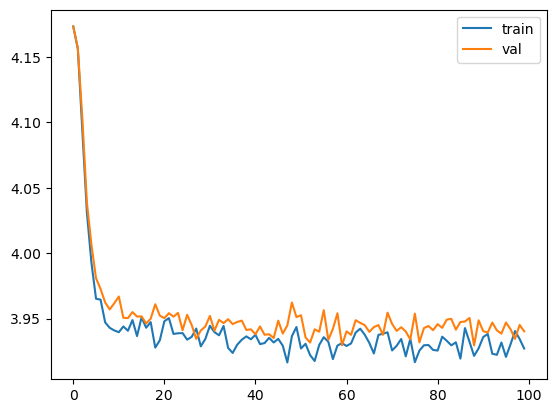

In [34]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10,
    'batch_size': 32,
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(), 
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

In [26]:
xs.shape

torch.Size([8, 16])

In [27]:
dataset.shape

torch.Size([1115393])